# Test 3
### Fit both a parametric lens model (SIE + shear) and a Sérsic source
as discussed in the meeting @Cubotron on 02.06.2021

__last update__: 12/07/21

In [1]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Basic imports
import time
import corner
import numpy as np
from copy import deepcopy
from scipy.optimize import minimize

# Basic JAX
import jax
from jax import lax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# JAX-ified lenstronomy
from jaxtronomy.Data.pixel_grid import PixelGrid
from jaxtronomy.Data.psf import PSF
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.ImSim.image_model import ImageModel
from jaxtronomy.Inference import Parameters, Optimizer, Sampler
from jaxtronomy.Util import image_util

# Universal font size
FS = 18

### Data grids (image plane and source plane)
For simplicity at first, assume both share the same pixelization.

In [2]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Source light model

In [3]:
source_light_model_list = ['SERSIC']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15}]

### Lens model (SIE + external shear)

In [4]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR']
lens_mass_model = LensModel(lens_mass_model_list)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                    {'gamma1': -0.01, 'gamma2': 0.03}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

kwargs_true = {'kwargs_lens': kwargs_lens_mass, 'kwargs_source': kwargs_source_light, 'kwargs_lens_light': kwargs_lens_light}

### PSF

In [5]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Image model

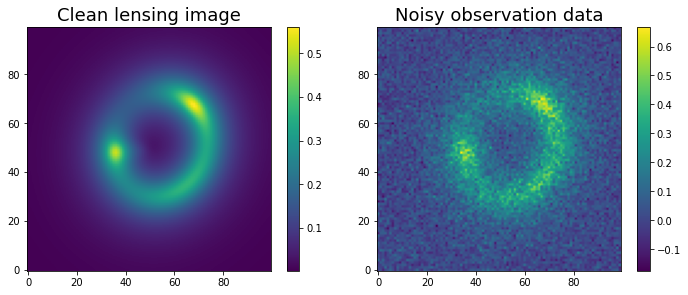

In [6]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}
image_model = ImageModel(data_class=pixel_grid,
                         psf_class=psf,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         point_source_class=None,
                         kwargs_numerics=kwargs_numerics)

image = image_model.image(kwargs_lens=kwargs_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light,
                          kwargs_ps={})

# Noise
exp_time = 100
sigma_bkd = 0.05
poisson = image_util.add_poisson(image, exp_time)
gaussian = image_util.add_background(image, sigma_bkd)

# Observed noisy data
data = image + gaussian + poisson

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower')
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower')
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

## Lens mass + source model fitting

### Parameter class

In [7]:
kwargs_model = {
    'lens_model_list': lens_mass_model_list,
    'source_model_list': source_light_model_list,
    'lens_light_model_list': lens_light_model_list,
}
kwargs_init = {
    'kwargs_lens': [{'theta_E': 1., 'e1': 1e-3, 'e2': 1e-3, 'center_x': 1e-3, 'center_y': 1e-3}, {'gamma1': 0., 'gamma2': 0.}],
    'kwargs_source': [{'amp': 1.0, 'R_sersic': 1.0, 'n_sersic': 1.0, 'center_x': 0.0, 'center_y': 0.0}],
}
kwargs_prior = {
    'kwargs_lens': [{}, {}],
    'kwargs_source': [{'amp': ['uniform', 0, 1e3], 'R_sersic': ['uniform', 1e-3, 1e1], 'n_sersic': ['uniform', 0.5, 8], 'center_x': ['uniform', -3., 3.], 'center_y': ['uniform', -3., 3.]}],
}
kwargs_fixed = {
    'kwargs_lens': [{}, {'ra_0': 0., 'dec_0': 0.}],
    'kwargs_source': [{}],
}
parameters = Parameters(kwargs_model, kwargs_init, kwargs_prior, kwargs_fixed)

p_true = parameters.kwargs2args(kwargs_true)
print("truths:", p_true)

print("priors:", parameters.prior_types)
print(parameters.bounds)
#print(parameters.log_prior(parameters.initial_values()))

truths: [ 1.6   0.15 -0.04  0.    0.   -0.01  0.03 10.    1.2   1.5   0.4   0.15]
priors: [None, None, None, None, None, None, None, 'uniform', 'uniform', 'uniform', 'uniform', 'uniform']
(array([   -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
        0.e+00,  1.e-03,  5.e-01, -3.e+00, -3.e+00]), array([  inf,   inf,   inf,   inf,   inf,   inf,   inf, 1000.,   10.,
          8.,    3.,    3.]))


### Loss function

In [8]:
def create_loss_func(data, model, param, noise_var=None):
    """Create a jit-compiled callable loss function.
    
    Parameters
    ----------
    data : 2D array
        Observed image.
    model : instance of a jaxtronomy ImageModel
        ImageModel instance with a callable image() method.
    noise_var : 2D array, optional
        Noise variance per pixel assuming independence, i.e.
        a diagonal covariance matrix.
    
    """
    if noise_var is None:
        noise_var = jnp.ones_like(data)
    assert noise_var.shape == data.shape, "Invalid noise variance map"
        
    def loss_func(kwargs):
        # Compute reconstruction with these parameters
        rec = model.image(**kwargs)
        
        # Chi-square
        #loss = 0.5 * jnp.mean((data - rec)**2 / noise_var)
        loss = 0.5 * jnp.sum((data - rec)**2 / noise_var)
        
        # negative log-prior
        #loss -= param.log_prior(param.kwargs2args(kwargs))
        
        # when using 'trust-constr' method in the optimizer below, we already take care of bounds, so we only include non-uniform priors here 
        loss -= param.log_prior_no_uniform(param.kwargs2args(kwargs))
        
        # Other regularisations
        # loss += ...
        
        return loss
    
    return jax.jit(loss_func)

# Create loss and grad(loss) functions of parameter dictionaries
noise_var = jnp.abs(image) / exp_time + gaussian.var()
loss = create_loss_func(data, image_model, parameters, noise_var=noise_var)
grad_loss = jax.jit(jax.grad(loss))

Check loss and gradient of the true parameters

In [9]:
loss(kwargs_true)

DeviceArray(4976.05331672, dtype=float64)

In [10]:
grad_loss(kwargs_true)

{'kwargs_lens': [{'center_x': DeviceArray(-47.52182162, dtype=float64),
   'center_y': DeviceArray(72.73293281, dtype=float64),
   'e1': DeviceArray(-74.94861889, dtype=float64),
   'e2': DeviceArray(-190.45723292, dtype=float64),
   'theta_E': DeviceArray(-528.70699869, dtype=float64)},
  {'gamma1': DeviceArray(208.89606761, dtype=float64),
   'gamma2': DeviceArray(-167.74222544, dtype=float64)}],
 'kwargs_lens_light': [{}],
 'kwargs_source': [{'R_sersic': DeviceArray(5.94662184, dtype=float64),
   'amp': DeviceArray(-4.48931319, dtype=float64),
   'center_x': DeviceArray(-236.5686261, dtype=float64),
   'center_y': DeviceArray(-187.36841713, dtype=float64),
   'n_sersic': DeviceArray(-46.16722644, dtype=float64)}]}

### Minimize the loss function over all parameters using scipy
Since scipy.minimize() takes a 1D input array of parameters, we have to make the nested dictionary of params used by the loss function above compatible with this. The code below is rather clumsy and could certainly be generalised to allow the user to decide (i.e. switch on and off) which parameters to fix and which to include in the fit.

In [12]:
# Optimise !
optimizer = Optimizer(loss, parameters)
best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method='BFGS', restart_from_init=True, 
                         use_exact_hessian_if_allowed=False)
print(f"Runtime: {runtime}")
kwargs_final = deepcopy(parameters.best_fit_values(as_kwargs=True))

Runtime: 18.6281259059906


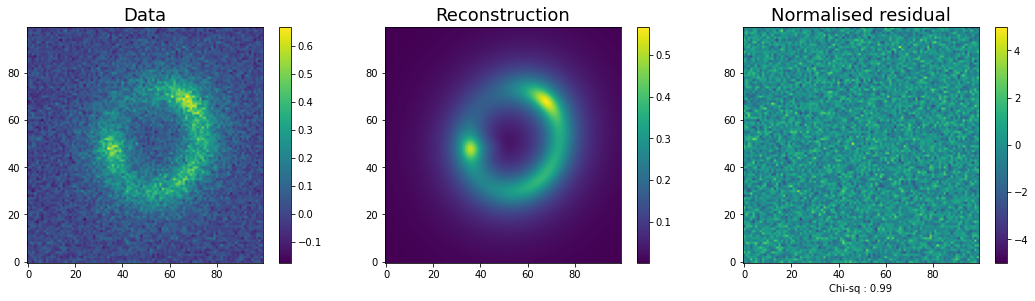

In [13]:
def plot_image_model(kwargs):
    rec = image_model.image(**kwargs)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    ax1, ax2, ax3 = axes
    img1 = ax1.imshow(data, origin='lower')
    ax1.set_title("Data", fontsize=FS)
    img2 = ax2.imshow(rec, origin='lower')
    ax2.set_title("Reconstruction", fontsize=FS)
    img3 = ax3.imshow((data - rec) / jnp.sqrt(noise_var), origin='lower', vmin=-5, vmax=5)
    ax3.set_title("Normalised residual", fontsize=FS)
    red_chi2 = np.sum((data - rec)**2 / noise_var) / data.size
    ax3.set_xlabel(f"Chi-sq : {red_chi2:.2f}")
    for img, ax in zip((img1, img2, img3), axes):
        fig.colorbar(img, ax=ax)
    fig.tight_layout()
    
plot_image_model(kwargs_final)

In [14]:
def print_errors(kwargs):
    def print_error_sgl(name, value, estimate):
        spaces = " " * (10 - len(name))
        if value != 0:
            error = 100 * abs(value - estimate) / value
            print(name + ":" + spaces + f"{error:.2f} %")
        else:
            error = abs(value - estimate)
            print(name + ":" + spaces + f"{error:.2f} (abs)")
    print("Error")
    print("-----")
    for i, params in enumerate(kwargs_lens_mass):
        for key, value in params.items():
            fit = kwargs['kwargs_lens'][i][key]
            print_error_sgl(key, value, fit)
    for params in kwargs_source_light:
        for key, value in params.items():
            fit = kwargs['kwargs_source'][0][key]
            print_error_sgl(key, value, fit)
        
print_errors(kwargs_final)

Error
-----
theta_E:   0.63 %
e1:        1.69 %
e2:        -68.68 %
center_x:  0.02 (abs)
center_y:  0.00 (abs)
gamma1:    -7.86 %
gamma2:    33.15 %
amp:       2.13 %
R_sersic:  0.06 %
n_sersic:  1.35 %
center_x:  0.93 %
center_y:  0.51 %


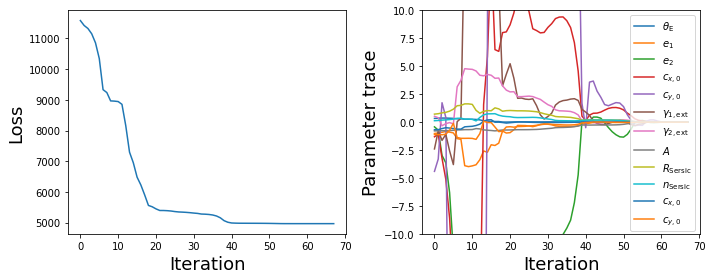

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
ax.plot(range(len(optimizer.loss_history)), optimizer.loss_history)
ax.set_ylabel("Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax = axes[1]
param_history = np.array(optimizer.param_history)
for i in range(len(parameters.symbols)):
    ax.plot(range(len(optimizer.loss_history)), (param_history[:, i] - param_history[-1, i]) / param_history[-1, i], label=parameters.symbols[i])
ax.set_ylabel("Parameter trace", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax.legend(loc='upper right')
ax.set_ylim(-10, 10)
fig.tight_layout()
plt.show()

### Fisher matrix

Using approximated inverse Hessian


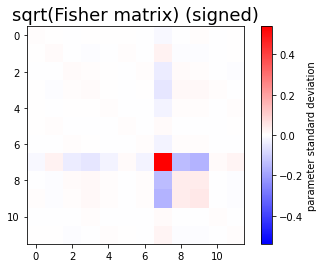

In [16]:
if extra_fields['hess_inv'] is not None:
    print("Using approximated inverse Hessian")
    fisher_matrix = extra_fields['hess_inv']
else:
    print("Using true inverse Hessian")
    hess_ml = optimizer.hessian(best_fit)
    fisher_matrix = jax.numpy.linalg.inv(hess_ml)

sqrt_fisher_matrix = np.sqrt(np.abs(fisher_matrix)) * np.sign(fisher_matrix)
plt.title("sqrt(Fisher matrix) (signed)", fontsize=FS)
plt.imshow(sqrt_fisher_matrix, cmap='bwr', vmin=-np.abs(sqrt_fisher_matrix).max(), vmax=np.abs(sqrt_fisher_matrix).max())
plt.colorbar(label="parameter standard deviation")
plt.show()

/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until


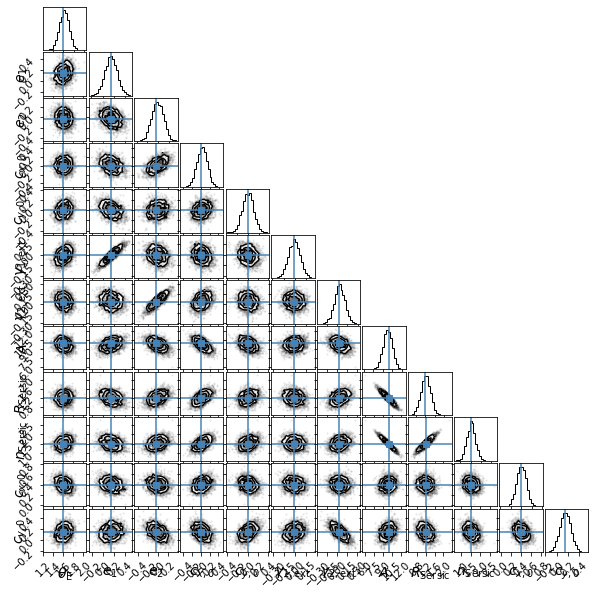

In [17]:
def draw_from_gaussian(mu, S, ndraws=1):
    ndim = len(mu)
    r = np.random.multivariate_normal(mu, S, size=ndraws)
    return r

samples_fisher = draw_from_gaussian(best_fit, sqrt_fisher_matrix, ndraws=3000)

fig = plt.figure(figsize=(8, 8))
fig = corner.corner(samples_fisher, truths=p_true, show_titles=False, labels=parameters.symbols, 
                    fig=fig, title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})
plt.show()

## Posterior inference with HMC

Using `numpyro`. Inspired by the [example code](http://num.pyro.ai/en/latest/examples/hmcecs.html#).

In [ ]:
sampler = Sampler(loss, parameters)
samples, logL, extra_fields, runtime = sampler.hmc(num_warmup=100, num_samples=2000, 
                                                   restart_from_init=False)
print(f"Runtime: {runtime}")
print(f"Samples shape: {samples.shape}")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
ax = axes[0]
ax.set_title("energy terms", fontsize=FS)
ax.plot(extra_fields['potential_energy'], label="potential")
ax.plot(extra_fields['energy'], label="potential + kinetic")
ax.legend()
ax = axes[1]
ax.set_title("acceptance probability", fontsize=FS)
ax.plot(extra_fields['accept_prob'])
plt.show()

In [ ]:
#print(extra_fields.keys())

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
ax = axes[0]
ax.set_title("energy terms", fontsize=FS)
ax.plot(extra_fields['potential_energy'], label="potential")
ax.plot(extra_fields['energy'], label="potential + kinetic")
ax.legend()
ax = axes[1]
ax.set_title("acceptance probability", fontsize=FS)
ax.plot(extra_fields['accept_prob'])
plt.show()

In [ ]:
kwargs_posterior = parameters.MAP_values(as_kwargs=True)
print(kwargs_posterior, loss(kwargs_posterior))

plot_image_model(kwargs_posterior)

In [ ]:
fig = corner.corner(samples, truths=p_true, show_titles=True, 
                    labels=parameters.symbols, 
                    title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})
plt.show()

In [ ]:
# compare uncertainties with Fisher information estimates
mcmc_std = samples.std(axis=0)
fisher_std = np.diag(np.sqrt(fisher_matrix))
print("MCMC uncertainties:", mcmc_std)
print("Fisher estimates (lower bound):", fisher_std)